## What we're going to learn

- Introduce transfer learning (a way to beat all of our old self-built models)
- Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Build a transfer learning feature extraction model using TensorFlow Hub
- Introduce the TensorBoard callback to track model training results
- Compare model results using TensorBoard

# Transfer Learning

**transfer learning**, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has **already learned** patterns on similar data to our own. This often results in achieving great results with less custom data.

Instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as [ImageNet](http://www.image-net.org/) (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

## Different types of transfer learning

* **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes.
* **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
* **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.


In [1]:
!nvidia-smi

Fri Sep 24 22:50:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Dataset

/content/drive/MyDrive/Dataset


In [ ]:
!ls

 10_food_classes_all_data       group1-shard9of10.bin
 10_food_classes_all_data.zip   kaggle.json
 ASLClassification	        __MACOSX
 batik_dataset		        Manuk
 batikology-dataset-main.zip    model.json
 cats_and_dogs_filtered.zip     model.png
 CK+			       'Murai Batu KOPSI 2021'
'CK+ augmented'		        pizza_steak
 group1-shard10of10.bin         pizza_steak.zip
 group1-shard5of10.bin	        rice-diseases-image-dataset
 group1-shard6of10.bin	       'Sampel Manuk Murai'
 group1-shard7of10.bin	       'SDUMLA Database'
 group1-shard8of10.bin	        tomato_4_classes


#Instead of using all of the data, we will using just 10% and see its result

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-09-24 21:16:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.6MB/s    in 4.0s    

2021-09-24 21:16:04 (40.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import os

# walk through pizza steak directory
for dirpath , dirnames, filenames in os.walk('/content/drive/MyDrive/Dataset/10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in /content/drive/MyDrive/Dataset/10_food_classes_10_percent
There are 10 directories and 0 images in /content/drive/MyDrive/Dataset/10_food_classes_10_percent/test
There are 0 directories and 250 images in /content/drive/MyDrive/Dataset/10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in /content/drive/MyDrive/Dataset/10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in /content/drive/MyDrive/Dataset/10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in /content/drive/MyDrive/Dataset/10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in /content/drive/MyDrive/Dataset/10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in /content/drive/MyDrive/Dataset/10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in /content/drive/MyDrive/Dataset/10_food_classes_10_percent/tes

In [5]:
train_dir = "/content/drive/MyDrive/Dataset/10_food_classes_10_percent/train"
test_dir = "/content/drive/MyDrive/Dataset/10_food_classes_10_percent/test"

In [6]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir) 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [7]:
# visualize our image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+'/'+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


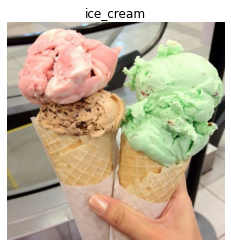

In [9]:
# view random image
img = view_random_image(target_dir =train_dir,
                        target_class = 'ice_cream')

## Prepare our data

the preparation include image augmentation, but we will use it later to see the powerfull of **transfer learning**

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [11]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=IMAGE_SHAPE,
                                                                   batch_size=BATCH_SIZE,
                                                                   class_mode='categorical',
                                                                   shuffle=True)
# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               shuffle=True) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Augmented training images:
Found 750 images belonging to 10 classes.
Non-augmented training images:
Found 750 images belonging to 10 classes.
Unchanged test images:
Found 2500 images belonging to 10 classes.


## introduction to callbacks 

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is **callbacks** (things to run whilst our model trains).

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
* [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.
* [**Custom Callcabks**](https://www.tensorflow.org/guide/keras/custom_callback) - create a custom callback, subclass `keras.callbacks.Callback` and override the method associated with the stage of interest.


In [12]:
# Tensorboard callback
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from [TensorFlow Hub](https://tfhub.dev/).

In fact, we're going to use two models from TensorFlow Hub:
1. [Inception](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5) -  a state of the art computer vision model architecture from 2015.
2. [EfficientNet](https://tfhub.dev/google/efficientnet/b0/feature-vector/1) - a state of the art computer vision architecture from 2021.

State of the art means that at some point, both of these models have achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks.

In [13]:
# Lets compare the following two models
inception_url = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5'

efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

In [14]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [16]:
# lets make the model from url
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

## Creating and testing model with InceptionV2 feature extraction 

In [17]:
train_data.num_classes

10

In [18]:
# Create model
inception_model = create_model(inception_url, num_classes=train_data.num_classes)

# Compile
inception_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [19]:
inception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              21802784  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


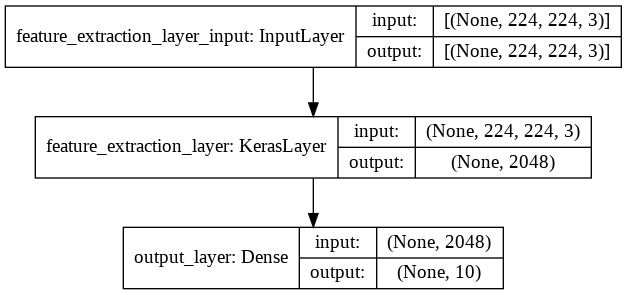

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(inception_model, show_shapes=True)

In [22]:
# Fit the model
inception_history = inception_model.fit(train_data,
                                     epochs=5,
                                     steps_per_epoch=len(train_data),
                                     validation_data=test_data,
                                     validation_steps=len(test_data),
                                     # Add TensorBoard callback to model (callbacks parameter takes a list)
                                     callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                            experiment_name="inceptionV3")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/inceptionV3/20210924-230214
Epoch 1/5
24/24 [==============================] - 1412s 59s/step - loss: 1.7177 - accuracy: 0.4147 - val_loss: 1.0265 - val_accuracy: 0.6708
Epoch 2/5
24/24 [==============================] - 27s 1s/step - loss: 0.9079 - accuracy: 0.7093 - val_loss: 0.8110 - val_accuracy: 0.7316
Epoch 3/5
24/24 [==============================] - 27s 1s/step - loss: 0.6933 - accuracy: 0.7813 - val_loss: 0.7282 - val_accuracy: 0.7620
Epoch 4/5
24/24 [==============================] - 27s 1s/step - loss: 0.5603 - accuracy: 0.8320 - val_loss: 0.6905 - val_accuracy: 0.7736
Epoch 5/5
24/24 [==============================] - 27s 1s/step - loss: 0.4598 - accuracy: 0.8760 - val_loss: 0.6499 - val_accuracy: 0.7904


wohooo its amzing... our inceptionV3 feature extraction boost the accuracy from 36% to 79% val_acc within 5 epoch **with only 10 percent of the training images!**

In [23]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

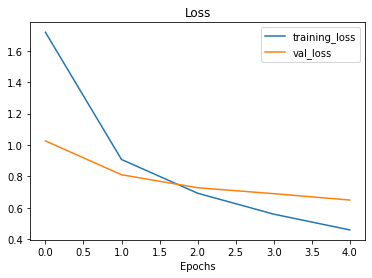

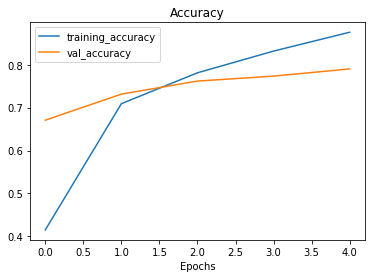

In [24]:
plot_loss_curves(inception_history)

## Creating and testing model with EfficienNetB0 feature extraction

In [25]:
# Create model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

# Compile
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [26]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


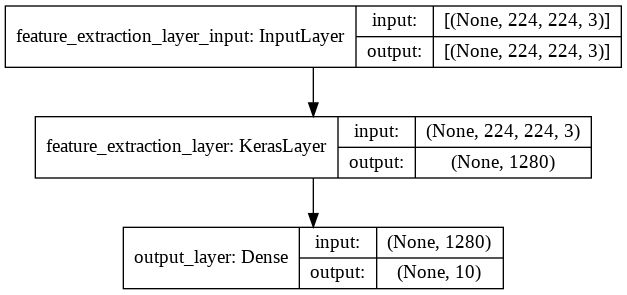

In [27]:
from keras.utils.vis_utils import plot_model
plot_model(efficientnet_model, show_shapes=True)

In [28]:
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              # Add TensorBoard callback to model (callbacks parameter takes a list)
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                                     experiment_name="efficientnetb0")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20210924-233644
Epoch 1/5
24/24 [==============================] - 33s 1s/step - loss: 1.8457 - accuracy: 0.4293 - val_loss: 1.3037 - val_accuracy: 0.7284
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.0652 - accuracy: 0.7747 - val_loss: 0.8673 - val_accuracy: 0.8132
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.7524 - accuracy: 0.8400 - val_loss: 0.7006 - val_accuracy: 0.8344
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.6037 - accuracy: 0.8693 - val_loss: 0.6090 - val_accuracy: 0.8544
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.5093 - accuracy: 0.8800 - val_loss: 0.5593 - val_accuracy: 0.8596


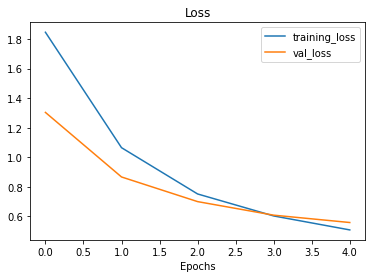

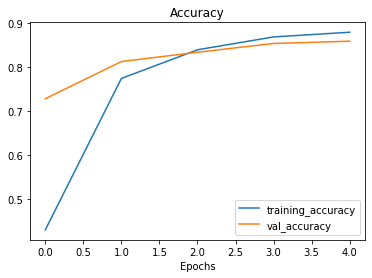

In [29]:
plot_loss_curves(efficientnet_history)

Wohoooo, its even better!! the EfficienNetB0 feature extraction **with less total params (4,062,374)** beat InceptionV3 with 21,823,274<br>

You can see different model on imageNet from this graph<br>
<a href="https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html">
    <img src="https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png" alt="image net" width="50%" height="50%">
  </a>




## Comparing model with tensorboard

**Note:** When you upload things to Tensorboard.dev, your experiments are public. So, if you're running private experiments (you dont want other to see) do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. InceptionV3" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

Our TensorBoard experiments are uploaded publically here : https://tensorboard.dev/experiment/EByErn6qQ2q6VuZYt6jJTw/